# Streaming

Streaming allows us to get real-time updates while the graph is running. In simple terms, when we use stream() instead of invoke(), we will recieve the output of graph step by step instead of wating for whole graph to finish and then get the output.

One of the main usecases of streaming in production is that we can update the UI elements wheile the graph is executing. but ofcourse it is also used for debugging and experimenting in development environment.

In [14]:
# Import libraries
import sys, os

In [15]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

In [58]:
# Create simple chatbot with summarization capability
from pprint import pprint
from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

## Simple Chatbot with tool

To understand the streaming concepts, let's first create a simple chatbot with summarization capability.

2025-09-09 13:58:54,566 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-09 13:58:55,497 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWNvbnZlcnNhdGlvbihjb252ZXJzYXRpb24pCgl0b29scyh0b29scykKCXN1bW1hcml6ZV9jb252ZXJzYXRpb24oc3VtbWFyaXplX2NvbnZlcnNhdGlvbikKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGNvbnZlcnNhdGlvbjsKCWNvbnZlcnNhdGlvbiAtLi0+IF9fZW5kX187Cgljb252ZXJzYXRpb24gLS4tPiBzdW1tYXJpemVfY29udmVyc2F0aW9uOwoJY29udmVyc2F0aW9uIC0uLT4gdG9vbHM7Cgl0b29scyAtLT4gY29udmVyc2F0aW9uOwoJc3VtbWFyaXplX2NvbnZlcnNhdGlvbiAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 15915


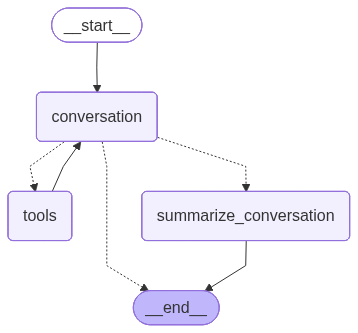

In [20]:
# LLM
model = ChatGoogleGenerativeAI(model=config.model.model_name, api_key=config.model.api_key)

# State
class State(MessagesState):
    summary: str

# Tools
@tool("Multiply", description="Multiply two numbers")
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool("add", description="Add two numbers")
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool("divide", description="Divide two numbers")
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Binf tools to the model
tools = [multiply, add, divide]
model_with_tools = model.bind_tools(tools)

# Nodes
def call_model(state: State, config: RunnableConfig) -> State:
    """
    This node checks if summary of conversation exists. If true, it adds it to the messages history before invoking the llm.
    if not, it only pass messages history.
    """
    # Get summary if exists
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else: 
        messages = state["messages"]

    response = model_with_tools.invoke(messages, config)
    return {"messages": [response]}

def summarize_conversation(state: State):
    """
    If a summary exits, this would update it and add new messages, but if not exist, this node will create new one.
    also it removes all messages form the history, but 2 most recent ones.
    """
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of conversation so far: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to out history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}


# Router
def router(state: State):
    """Return the next node after llm_call"""

    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END


# Define Workflow
workflow = StateGraph(State)

workflow.add_node("conversation", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", tools_condition)
workflow.add_edge("tools", "conversation")
workflow.add_conditional_edges(
    "conversation",
    router,
    {
        "summarize_conversation": "summarize_conversation",
        END: END,
    },
)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({"messages": "what does it times 10?"}, config=config):
    print(chunk, "\n")

{'conversation': {'messages': [AIMessage(content='Please provide the number you would like to multiply by 10.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--de29ac20-d284-44f7-bee0-97f294c39c5d-0', usage_metadata={'input_tokens': 141, 'output_tokens': 121, 'total_tokens': 262, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 107}})]}} 



As shown above, we can see the state after each node! but it does not stop here, we can pass `stream_mode` parameter value. here is a list of what we have: 

1. **`values`**: Streams the full value of the state after each step of the graph.
2. **`updates`**: Streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g., multiple nodes are run), those updates are streamed separately.
3. **`custom`**: Streams custom data from inside your graph nodes.
4. **`messages`**: Streams 2-tuples (LLM token, metadata) from any graph nodes where an LLM is invoked.
5. **`debug`**: Streams as much information as possible throughout the execution of the graph.

---
# Breakpoints

Sometimes we need to interrupt our workflow, send state to a user, and allow the user to accept an action or maybe we want to modify our state! here is when we use interrupt. In the following example, we use compile the same graph, but this time, with interrupt

2025-09-09 14:25:57,880 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-09 14:25:58,622 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWNvbnZlcnNhdGlvbihjb252ZXJzYXRpb24pCgl0b29scyh0b29sczxoci8+PHNtYWxsPjxlbT5fX2ludGVycnVwdCA9IGJlZm9yZTwvZW0+PC9zbWFsbD4pCglzdW1tYXJpemVfY29udmVyc2F0aW9uKHN1bW1hcml6ZV9jb252ZXJzYXRpb24pCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBjb252ZXJzYXRpb247Cgljb252ZXJzYXRpb24gLS4tPiBfX2VuZF9fOwoJY29udmVyc2F0aW9uIC0uLT4gc3VtbWFyaXplX2NvbnZlcnNhdGlvbjsKCWNvbnZlcnNhdGlvbiAtLi0+IHRvb2xzOwoJdG9vbHMgLS0+IGNvbnZlcnNhdGlvbjsKCXN1bW1hcml6ZV9jb252ZXJzYXRpb24gLS0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 18184


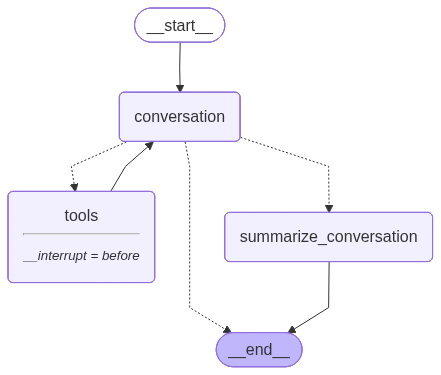

In [52]:
# Compile
memory = MemorySaver()
graph = workflow.compile(interrupt_before=["tools"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "11"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  Multiply (041898ef-f705-41d6-b8c7-997fc44a6b49)
 Call ID: 041898ef-f705-41d6-b8c7-997fc44a6b49
  Args:
    a: 2.0
    b: 3.0


In [60]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='93cfa7c5-5e2a-47d7-8fb8-dfedd60d9304'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'Multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--86ce23bb-fb09-40fc-944e-e876ed792c37-0', tool_calls=[{'name': 'Multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '041898ef-f705-41d6-b8c7-997fc44a6b49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 139, 'output_tokens': 67, 'total_tokens': 206, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 49}})]}, next=('tools',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f08d6fd-8823-6d5a-8001-df6061a8ca8b'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_a

In [61]:
state.next

('tools',)

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

In [62]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Multiply (041898ef-f705-41d6-b8c7-997fc44a6b49)
 Call ID: 041898ef-f705-41d6-b8c7-997fc44a6b49
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: Multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [63]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  Multiply (3b4f0425-a85e-4d02-86fb-e93ba1490bd6)
 Call ID: 3b4f0425-a85e-4d02-86fb-e93ba1490bd6
  Args:
    a: 2.0
    b: 3.0


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  Multiply (3b4f0425-a85e-4d02-86fb-e93ba1490bd6)
 Call ID: 3b4f0425-a85e-4d02-86fb-e93ba1490bd6
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: Multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [74]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='590be358-fc8a-46c2-91f7-3e6978fdf81e')]}, next=('conversation',), config={'configurable': {'thread_id': '121323123123', 'checkpoint_ns': '', 'checkpoint_id': '1f08d864-5128-6bd0-8000-444bc93f913f'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-09-09T14:07:07.246268+00:00', parent_config=None, tasks=(PregelTask(id='4c851cd0-2031-dd57-df33-fb82b36a8270', name='conversation', path=('__pregel_pull', 'conversation'), error=None, interrupts=(), state=None, result=None),), interrupts=())

# Editing graph state on interupt

when interupt occurs on our workflow, we can update the state with the following command

In [75]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '121323123123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08d865-1baa-6c3c-8001-2570bf489cfe'}}

In [76]:
state

StateSnapshot(values={'messages': [HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='590be358-fc8a-46c2-91f7-3e6978fdf81e')]}, next=('conversation',), config={'configurable': {'thread_id': '121323123123', 'checkpoint_ns': '', 'checkpoint_id': '1f08d864-5128-6bd0-8000-444bc93f913f'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-09-09T14:07:07.246268+00:00', parent_config=None, tasks=(PregelTask(id='4c851cd0-2031-dd57-df33-fb82b36a8270', name='conversation', path=('__pregel_pull', 'conversation'), error=None, interrupts=(), state=None, result=None),), interrupts=())